# EVPN-MPLS with Nornir Part 2: VLAN-Aware EVI and Multihoming
* This lab follows the evp_l2_with_nornir.ipynb lab

* RFC 7432
* VLAN-Based EVI
    * Use instance-type evpn
    * use vlan-id <#>
    * One bridge domain with automatic VLAN normalization
* VLAN-Aware Bundle EVI
    * Use instance-type virtual-switch
    * Each bridge domain aware of the VLAN ID that it hosts
    * Each VLAN gets its own named bridge domain
    * Multiple bridge domains within the one routing instance

* VLAN Bundle (less common)
    * No explicit VLAN configuration
    * One bridge domain with **no** VLAN awareness
    * No normalization
    * Not configured in these labs

## Configs

##### Basic VLAN-Aware EVPN
```
# Turn on EVPN address family
set protocols bgp group INTERNAL family evpn signaling

# Optional, used for L3VPNs, but can be combined with EVPN-MPLS:
set protocols bgp group INTERNAL family inet-vpn unicast

# For RR if OOB
set routing-options resolution rib bgp.evpn.0 resolution-ribs inet.0

# Suggested to enable load-balancing
set policy-options policy-statement LB then load-balance per-packet # newer Junos versions actually have the 'per-flow' statement
set routing-options forwarding-table export LB

# Routing Instance for VLAN-Aware Bundle EVI
set routing-instances VLAN_AWARE_EVI instance-type virtual-switch       <-VLAN-Aware Bundle; user virtual-switch
set routing-instances VLAN_AWARE_EVI interface ge-0/0/1.90
set routing-instances VLAN_AWARE_EVI interface ge-0/0/2.90
set routing-instances VLAN_AWARE_EVI interface ge-0/0/3.90
set routing-instances VLAN_AWARE_EVI route-distinguisher 10.1.1.1:90 
set routing-instances VLAN_AWARE_EVI vrf-target target:64512:90
set routing-instances VLAN_AWARE_EVI protocols evpn extended-vlan-list  [150, 250, 350, 450]

# Named bridge-domains

set routing-instances VLAN_AWARE_EVI bridge-domains v150 vlan-id 150 
set routing-instances VLAN_AWARE_EVI bridge-domains v150 vlan-id 250 
set routing-instances VLAN_AWARE_EVI bridge-domains v150 vlan-id 350 
set routing-instances VLAN_AWARE_EVI bridge-domains v150 vlan-id 450 

```

##### CE Facing Interface
```
set interfaces ge0/0/4 flexible-vlan-tagging
set interfaces ge0/0/4 encapsulation flexible-ethernet-services
set interfaces ge0/0/4 unit 1234 family bridge vlan-id-list [ 150 250 350 250 ]
set interfaces ge0/0/4 unit 1234 family bridge interface-mode trunk
```


## Verification

```
show bgp summary
show evpn instance MY_EVI extensive
show route table bgp.evpn.0 match-prefix "2:10.22.22.22:100:*"   <---Filter on Type 2 routes
show route table bgp.evpn.0 match-prefix "3:10.22.22.22:100:*"   <---Filter on Type 3 routers

show evpn database
#show evpn mac-table     <----User for VLAN-Based EVIs
show bridge mac-table   <----Use for VLAN-Aware EVIs
```
* Route format from bpg.evpn.0 table:
```
    Route-Type(2) : RD :: VLAN-ID : MAC /304-bits long
    2:10.22.22.22:100::100::50:00:00:08:00:05/304 MAC/IP        
    
    Route-Type(2) : RD :: VLAN-ID : MAC:IP /304-bits long
    2:10.22.22.22:100::100::50:00:00:08:00:05::10.100.100.22/304 MAC/IP        
    
    Route-Type(3) : RD : VLAN-ID : Advertising PE's loopback IP /248-bits long
    3:10.22.22.22:100::100::10.22.22.22/248 IM            
```


## Topology
* Physical Topology from EVE-NG
* TODO: Draw up logical topology
* All core P devices are running basic Cisco IOS images as these require less resources. They are configured with basic MPLS/LDP/ISIS.
* Customer devices are set up as Logical-Systems on the vMXs and connected via the EVE-NG bridges, except for the multihomed client, CE-42-MH, running as a Cisco IOS device.
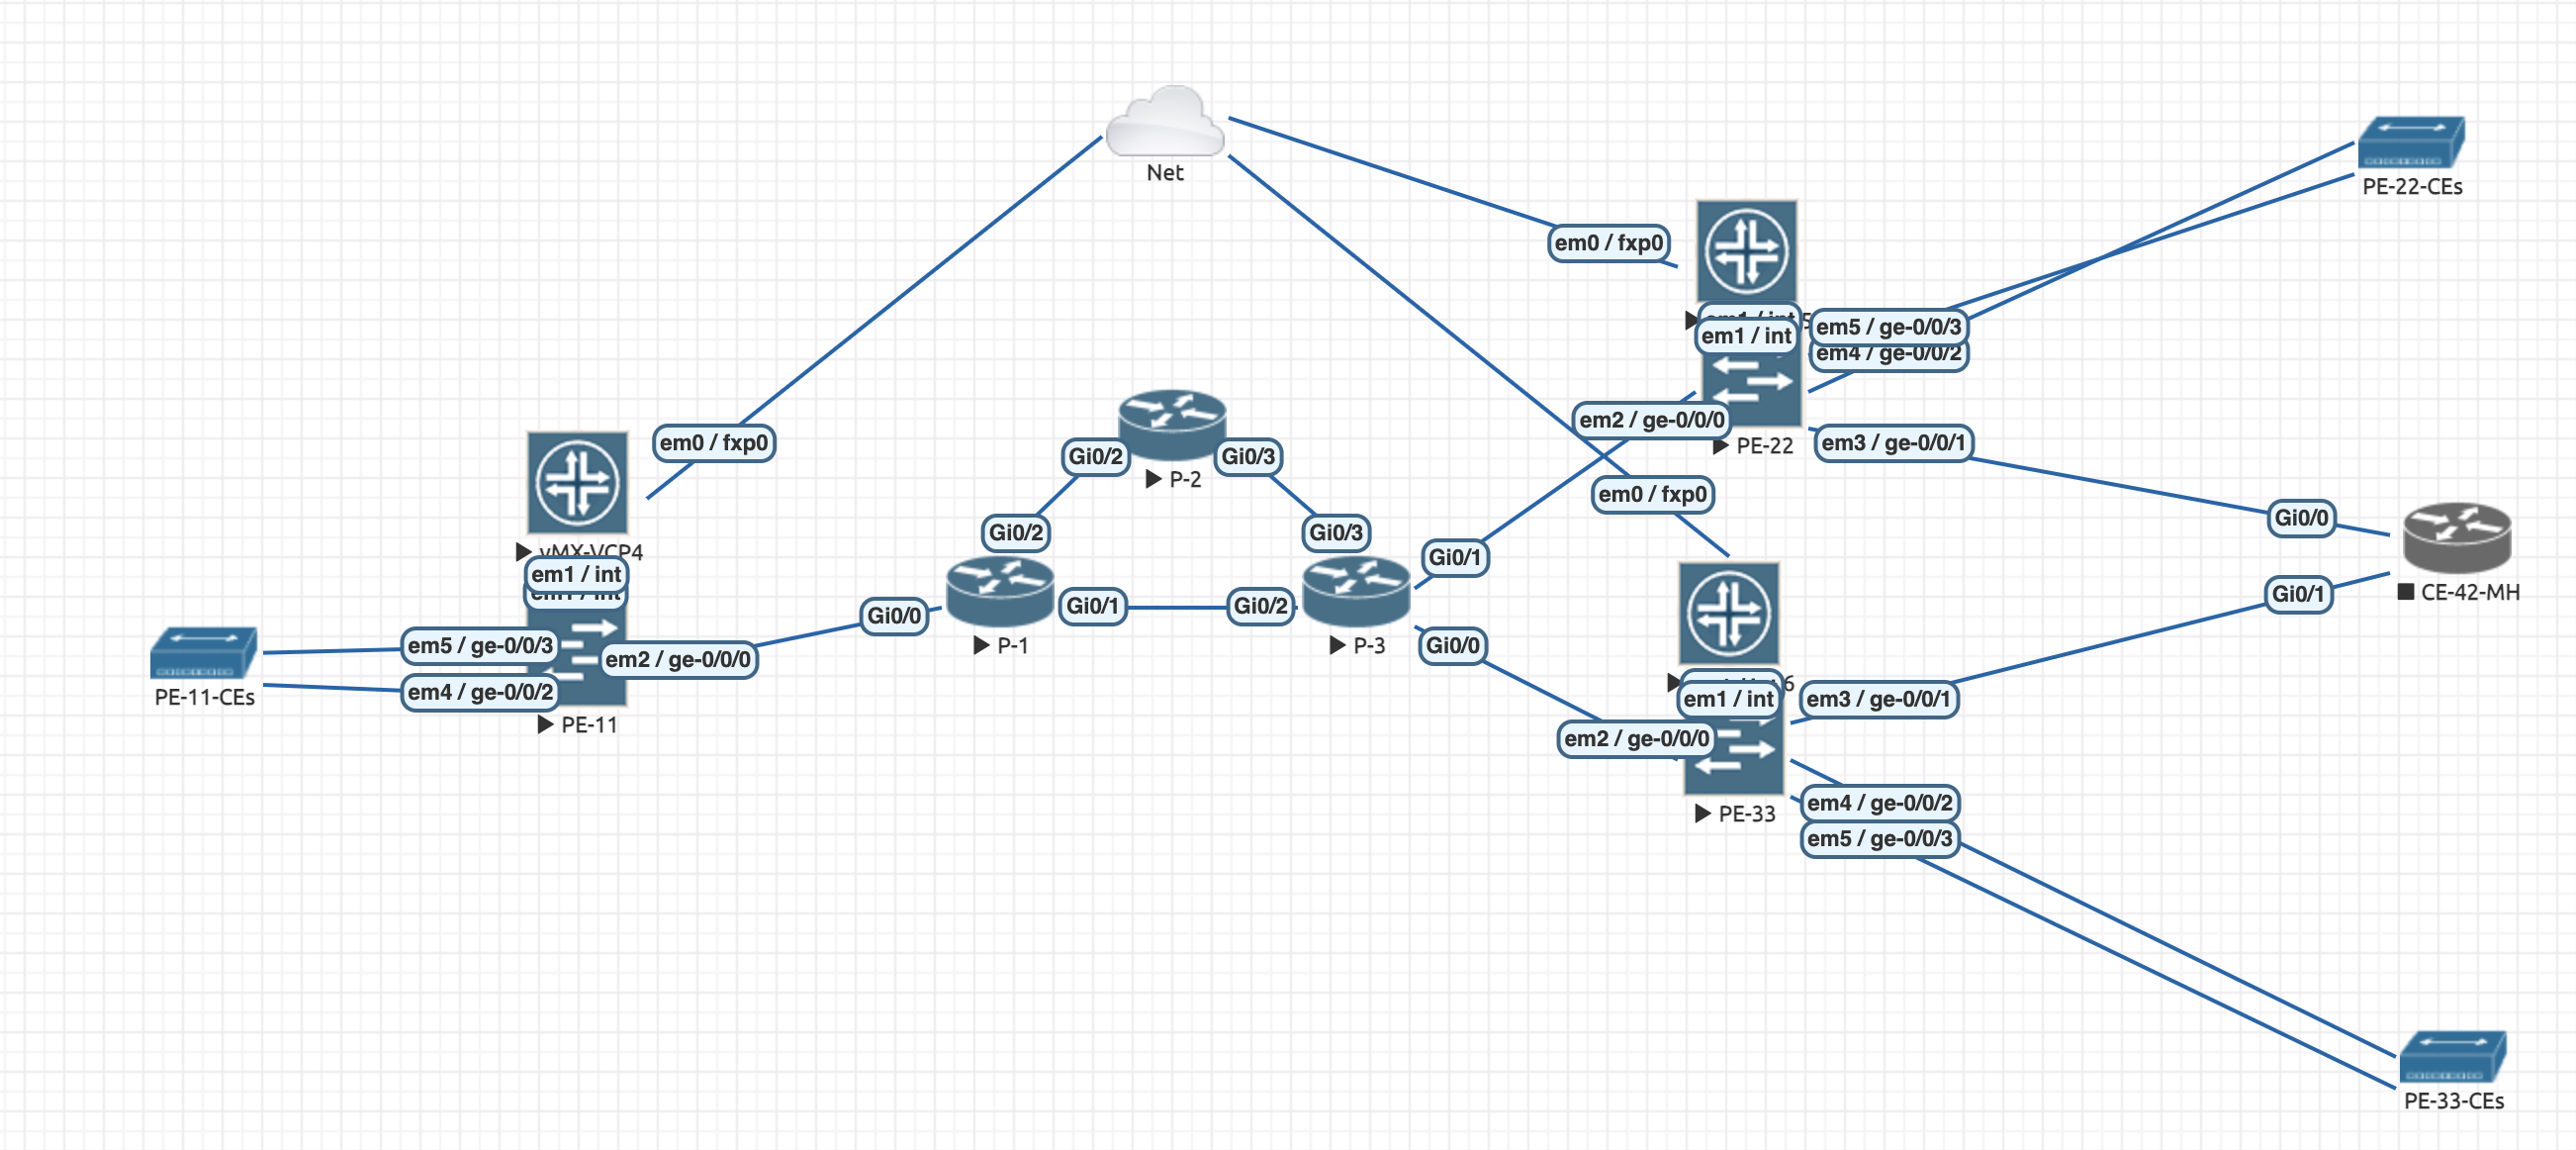

In [2]:
import logging
import os
from nornir import InitNornir
from nornir_utils.plugins.functions import print_result
from nornir_napalm.plugins.tasks import napalm_get, napalm_cli, napalm_configure
from nornir.core.task import Task, Result

In [3]:
nr = InitNornir(config_file="nornir_inventory/config.yml")

In [4]:
def backup_all_configs(nr, backup_dir="backups", file_name_suffix=""):
    """Backs up running configurations from all devices in Nornir inventory."""
    os.makedirs(backup_dir, exist_ok=True)
    def backup_config(task):
        result = task.run(task=napalm_get, getters=["config"])
        config_data = result.result["config"]["running"]
        if not file_name_suffix:
            backup_filename = f"{backup_dir}/{task.host}_nornir_backup.conf"
        else:
            backup_filename = f"{backup_dir}/{task.host}_{file_name_suffix}_backup.conf"
        with open(backup_filename, "w") as backup_file:
            backup_file.write(config_data)
        print(f"Backup saved: {backup_filename}")
    nr.run(task=backup_config)

def restore_all_configs(nr, backup_dir="backups", file_name_suffix=""):
    """Restores all device configurations from the latest backup in the specified folder."""
    def restore_config(task):
        try:
            if not file_name_suffix:
                backup_filename = f"{backup_dir}/{task.host}_nornir_backup.conf"
            else:
                backup_filename = f"{backup_dir}/{task.host}_{file_name_suffix}_backup.conf"
            with open(backup_filename, "r") as file:
                config_data = file.read()
            task.run(task=napalm_configure, configuration=config_data, replace=True)
            print(f"Configuration restored for {task.host} from {backup_filename}")
        except Exception as err:
            print(f"No backup not found for {task.host}")
            print(err)
    nr.run(task=restore_config)

In [5]:
# Backup lab to start
#backup_all_configs(nr)
restore_all_configs(nr)

✅ Configuration restored for PE-22 from backups/PE-22_nornir_backup.conf
✅ Configuration restored for PE-11 from backups/PE-11_nornir_backup.conf
✅ Configuration restored for PE-33 from backups/PE-33_nornir_backup.conf


## Configure BGP for EVPN

In [6]:
nr = InitNornir(config_file="nornir_inventory/config.yml")
def bgp(task):
    bgp_config = [ 
            "set protocols bgp group INTERNAL type internal",
            "set protocols bgp group INTERNAL family evpn signaling",
            "set protocols bgp group INTERNAL family inet-vpn unicast",
            f"set protocols bgp group INTERNAL local-address {task.host.data['loopback']}",
    ]
    try:
        for neighbor in task.host.data['bgp_neighbors']:
            bgp_config.append(f"set protocols bgp group INTERNAL neighbor {neighbor}")
        bgp_config = "\n".join(bgp_config)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration=bgp_config)
    except Exception as err:
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration="rollback 0")
        print("Error:", err)

In [7]:
result = nr.run(bgp)
print_result(result, severity_level=logging.DEBUG)

bgp*****************************************************************************
* PE-11 ** changed : True ******************************************************
vvvv bgp ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DEBUG
[edit protocols]
+   bgp {
+       group INTERNAL {
+           type internal;
+           local-address 10.11.11.11;
+           family inet-vpn {
+               unicast;
+           }
+           family evpn {
+               signaling;
+           }
+           neighbor 10.22.22.22;
+           neighbor 10.33.33.33;
+       }
}
^^^^ END bgp ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
* PE-22 ** changed : True ******************************************************
vvvv bgp ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DE

## Load-balancing for EVPN

In [8]:
nr = InitNornir(config_file="nornir_inventory/config.yml")
def load_balance(task):
    lb_config = [
            "set policy-options policy-statement LB then load-balance per-packet",
            "set routing-options forwarding-table export LB",
    ]
    try:
        lb_config = "\n".join(lb_config)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration=lb_config)
    except Exception as err:
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration="rollback 0")
        print("Error:", err)

In [9]:
result = nr.run(load_balance)
print_result(result, severity_level=logging.DEBUG)

load_balance********************************************************************
* PE-11 ** changed : True ******************************************************
vvvv load_balance ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DEBUG
[edit routing-options]
+   forwarding-table {
+       export LB;
+   }
[edit]
+  policy-options {
+      policy-statement LB {
+          then {
+              load-balance per-packet;
+          }
+      }

^^^^ END load_balance ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
* PE-22 ** changed : True ******************************************************
vvvv load_balance ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DEBUG
[edit routing-options]
+   forwarding-table {
+       export LB;
+   }
[edit]
+  policy-options {
+      policy-statement 

## EVPN VLAN-Aware Bundle Routing-Instance

In [10]:
nr = InitNornir(config_file="nornir_inventory/config.yml")

def evpn_routing_instance(task, evpn_aware_instance=True):
    if not evpn_aware_instance:
        routing_instance_config = [
                "set routing-instances VLAN_BASED_EVI instance-type evpn",
                "set routing-instances VLAN_BASED_EVI vlan-id 100",
                f"set routing-instances VLAN_BASED_EVI route-distinguisher {task.host.data['loopback']}:100",
                "set routing-instances VLAN_BASED_EVI vrf-target target:64512:100",
                "set routing-instances VLAN_BASED_EVI protocols evpn",
        ]
    if evpn_aware_instance:
        routing_instance_config = [
                "set routing-instances VLAN_AWARE_EVI instance-type virtual-switch",
                f"set routing-instances VLAN_AWARE_EVI route-distinguisher {task.host.data['loopback']}:1234",
                "set routing-instances VLAN_AWARE_EVI vrf-target target:64512:1234",
                "set routing-instances VLAN_AWARE_EVI protocols evpn extended-vlan-list [ 150 250 350 450 ]",
                "set routing-instances VLAN_AWARE_EVI bridge-domains v150 vlan-id 150",
                "set routing-instances VLAN_AWARE_EVI bridge-domains v250 vlan-id 250",
                "set routing-instances VLAN_AWARE_EVI bridge-domains v350 vlan-id 350",
                "set routing-instances VLAN_AWARE_EVI bridge-domains v450 vlan-id 450",
        ]
    try:
        routing_instance_config = "\n".join(routing_instance_config)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration=routing_instance_config)
    except Exception as err:
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration="rollback 0")
        print("Error:", err)

In [11]:
result = nr.run(evpn_routing_instance)
print_result(result, severity_level=logging.DEBUG)

evpn_routing_instance***********************************************************
* PE-11 ** changed : True ******************************************************
vvvv evpn_routing_instance ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DEBUG
[edit]
+  routing-instances {
+      VLAN_AWARE_EVI {
+          instance-type virtual-switch;
+          route-distinguisher 10.11.11.11:1234;
+          vrf-target target:64512:1234;
+          protocols {
+              evpn {
+                  extended-vlan-list [ 150 250 350 450 ];
+              }
+          }
+          bridge-domains {
+              v150 {
+                  vlan-id 150;
+              }
+              v250 {
+                  vlan-id 250;
+              }
+              v350 {
+                  vlan-id 350;
+              }
+              v450 {
+                  vlan-id 450;
+              }
+          }
+      }

^^^^ END ev

#### PE TO CE Interfaces

In [12]:
nr = InitNornir(config_file="nornir_inventory/config.yml")
def evpn_pe_to_ce_interface(task, evpn_aware_instance=True):
    if not evpn_aware_instance:
        pe_to_ce_config = [
                "set interfaces ge0/0/2 flexible-vlan-tagging",
                "set interfaces ge0/0/2 encapsulation flexible-ethernet-services",
                "set interfaces ge0/0/2 unit 100 encapsulation vlan-bridge",
                "set interfaces ge0/0/2 unit 100 vlan-id 100",
                "set interfaces ge0/0/2 unit 100 family bridge",
                "set routing-instances VLAN_BASED_EVI interface ge-0/0/2.100",
        ]
    if evpn_aware_instance:
        pe_to_ce_config = [
                "set interfaces ge0/0/2 flexible-vlan-tagging",
                "set interfaces ge0/0/2 encapsulation flexible-ethernet-services",
                "set interfaces ge0/0/2 unit 1234 family bridge vlan-id-list [ 150 250 350 450 ]",
                "set interfaces ge0/0/2 unit 1234 family bridge interface-mode trunk",
                "set routing-instances VLAN_AWARE_EVI interface ge-0/0/2.1234",
        ]
    try:
        pe_to_ce_config = "\n".join(pe_to_ce_config)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration=pe_to_ce_config)
    except Exception as err:
        print("Error:", err)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration="rollback 0")

In [13]:
result = nr.run(evpn_pe_to_ce_interface)
print_result(result, severity_level=logging.DEBUG)

evpn_pe_to_ce_interface*********************************************************
* PE-11 ** changed : True ******************************************************
vvvv evpn_pe_to_ce_interface ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DEBUG
[edit interfaces]
+   ge-0/0/2 {
+       flexible-vlan-tagging;
+       encapsulation flexible-ethernet-services;
+       unit 1234 {
+           family bridge {
+               interface-mode trunk;
+               vlan-id-list [ 150 250 350 450 ];
+           }
+       }
+   }
[edit routing-instances VLAN_AWARE_EVI]
 interface ge-0/0/2.1234;
^^^^ END evpn_pe_to_ce_interface ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
* PE-22 ** changed : True ******************************************************
vvvv evpn_pe_to_ce_interface ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True -------------------------------

#### Logical-System CE Interfaces (not multi-homed)

In [14]:
nr = InitNornir(config_file="nornir_inventory/config.yml")
def evpn_ls_ce_interface(task, evpn_aware_instance=True):
    if not evpn_aware_instance:
        ls_ce_config = [
                "set interfaces ge-0/0/3 flexible-vlan-tagging",
                "set interfaces ge-0/0/3 encapsulation flexible-ethernet-services",
                "set logical-systems CE100 interfaces ge-0/0/3 unit 100 vlan-id 100",
                f"set logical-systems CE100 interfaces ge-0/0/3 unit 100 family inet address 10.100.100.{task.host.data['final_octet']}/24",
        ]
    if evpn_aware_instance:
        ls_ce_config = [
                "set interfaces ge-0/0/3 flexible-vlan-tagging",
                "set interfaces ge-0/0/3 encapsulation flexible-ethernet-services",
                "set logical-systems CE150 interfaces ge-0/0/3 unit 150 vlan-id 150",
                f"set logical-systems CE150 interfaces ge-0/0/3 unit 150 family inet address 10.15.0.{task.host.data['final_octet']}/24",
                "set logical-systems CE250 interfaces ge-0/0/3 unit 250 vlan-id 250",
                f"set logical-systems CE250 interfaces ge-0/0/3 unit 250 family inet address 10.25.0.{task.host.data['final_octet']}/24",
                "set logical-systems CE350 interfaces ge-0/0/3 unit 350 vlan-id 350",
                f"set logical-systems CE350 interfaces ge-0/0/3 unit 350 family inet address 10.35.0.{task.host.data['final_octet']}/24",
                "set logical-systems CE450 interfaces ge-0/0/3 unit 450 vlan-id 450",
                f"set logical-systems CE450 interfaces ge-0/0/3 unit 450 family inet address 10.45.0.{task.host.data['final_octet']}/24",
        ]
    try:
        ls_ce_config = "\n".join(ls_ce_config)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration=ls_ce_config)
    except Exception as err:
        print("Error:", err)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration="rollback 0")

In [15]:
result = nr.run(evpn_ls_ce_interface)
print_result(result, severity_level=logging.DEBUG)

evpn_ls_ce_interface************************************************************
* PE-11 ** changed : True ******************************************************
vvvv evpn_ls_ce_interface ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DEBUG
[edit logical-systems]
+  CE150 {
+      interfaces {
+          ge-0/0/3 {
+              unit 150 {
+                  vlan-id 150;
+                  family inet {
+                      address 10.15.0.11/24;
+                  }
+              }
+          }
+      }
+  }
+  CE250 {
+      interfaces {
+          ge-0/0/3 {
+              unit 250 {
+                  vlan-id 250;
+                  family inet {
+                      address 10.25.0.11/24;
+                  }
+              }
+          }
+      }
+  }
+  CE350 {
+      interfaces {
+          ge-0/0/3 {
+              unit 350 {
+                  vlan-id 350;
+                  fa

# Multihoming

* All active mode; multi-live links all at once :)
* Place CE links in a LAG with LACP configured; LAG terminates on different PEs
* No special config for the CE 
* CE could be SP managed and set-up to service multiple clients 
    * Generally uses virtual-router for this

#### Type 1 Route Ethernet Auto-Discovery... :

* Prevent loops
* Two types of Type 1 routes
    * Type 1 Ethernet Auto-Discovery Per-Ethernet Segment
        * Contains:
            * Route-Targets for all EVIs on the segment
            * ESI MPLS Label (BGP community)
            * The ESI
            * MPLS Label: **0**
            * Ethernet Tag ID set to 4294967295
            * and more...
        * Functions:
            * Mass MAC withdrawal
            * Loop Prevention from flooded frames from the CE
        * Lets you know the ESI exists 
    * Type 1 Ethernet Auto-Discovery Per-EVI
        * Aliasing: enables PEs to load-balance in all-active mode
        * Backup Paths: Faster failover in single-active mode
        * Lets actually send traffic to devices connected to that ESI
        * Contains:
            * A single Route-Target
            * The ESI
            * MPLS Label: the aliasing label
            * Ethernet Tag ID set to 0 or VLAN ID of the bridge domain
* Learned by all PEs in the EVPN
* `show route table bgp.evpn.0 match-prefix "1:*" [detail]`

#### Type 4 Ethernet Segment Route:

* Prevent loops from remote PEs
* If the CE interfaces were not configured as a LAG, a loop could occur
* Only used by PE devices on the same Ethernet Segment (Multi-homed Link)
* Discover other PEs on the segment
* Elect a Designated Forwarder
    * Only one PE elected to forward BUM traffic to the CE
    * Elected per EVI (service-carving)
* Include the nonzero ESI and a separate auto-generated route-target (ES RT)
* Advertises the segment itself
    * Not concerned about VPNs
* `show route table bgp.evpn.0 match-prefix "4:*" [detail]`
* `show evpn instance KICIAKOCIA designated-forwarder`

    
##### CE Interface:
```
set chassis aggregated-devices ethernet device-count 1
set interfaces ge-0/0/0 gigether-options 802.3ad ae0
set interfaces ge-0/0/1 gigether-options 802.3ad ae0

set interfaces ae 0 flexible-vlan-tagging
set interfaces ae 0 mac 00:11:22:33:55:66
set interfaces ae 0 aggregated-ether-options lacp active
set interfaces ae 0 unit 150 vlan-id 150 
set interfaces ae 0 unit 150 family inet address 10.150.150.44/24
set interfaces ae 0 unit 250 vlan-id 250 
set interfaces ae 0 unit 250 family inet address 10.250.250.44/24
```

##### PEs Interface:

* ESI can only be used for one ESI!
```
# Configure on both PEs
set chassis aggregated-devices ethernet device-count 1
set interfaces ge-0/0/0 gigether-options 802.3ad ae0                          <---Only single link needed per PE

set interfaces ae 0 aggregated-ether-options lacp system-id 22:33:22:33:22:33 <---Must match on both PEs
set interfaces ae 0 esi 00:22:33:22:33:22:33:22:33:23                         <---First octet defines type; type 00 here; ESI must match on both PEs
set interfaces ae 0 esi all-active

set interfaces ae 0 flexible-vlan-tagging
set interfaces ae 0 encapsulation flexible-ethernet-services
set interfaces ae 0 unit 100 encapsulation vlan-bridge
set interfaces ae 0 unit 100 vlan-id 100
set interfaces ae 0 unit 100 family bridge
set interfaces ae 0 unit 1234 family bridge interface-mode trunk
set interfaces ae 0 unit 1234 family bridge vlan-id-list [ 150 250 350 450 ]
```


In [16]:
def multi_homed_pe_interface(task):
    multi_homed_pe_config = [
            "set chassis aggregated-devices ethernet device-count 1",
            "set interfaces ge-0/0/1 gigether-options 802.3ad ae0",
            
            "set interfaces ae0 aggregated-ether-options lacp system-id 22:33:22:33:22:33",
            #"set interfaces ae0 aggregated-ether-options lacp active",
            # Using 'force-up' as LAG interfaces were not available on the Cisco IOS lab device
            # will need to replace the Cisco IOS with vCSR IOS-XE to test on CE.
            "set interfaces ae0 aggregated-ether-options lacp force-up",
            "set interfaces ae0 esi 00:22:33:22:33:22:33:22:33:23",
            "set interfaces ae0 esi all-active",
            
            "set interfaces ae0 flexible-vlan-tagging",
            "set interfaces ae0 encapsulation flexible-ethernet-services",
        
            #"set interfaces ae0 unit 100 encapsulation vlan-bridge",
            #"set interfaces ae0 unit 100 vlan-id 100",
            #"set interfaces ae0 unit 100 family bridge",
        
            "set interfaces ae0 unit 1234 family bridge interface-mode trunk",
            "set interfaces ae0 unit 1234 family bridge vlan-id-list [ 150 250 350 450 ]",
        
            #"set routing-instances VLAN_BASED_EVI interface ae0.100",
            "set routing-instances VLAN_AWARE_EVI interface ae0.1234",
    ]
    try:
        multi_homed_pe_config = "\n".join(multi_homed_pe_config)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration=multi_homed_pe_config)
    except Exception as err:
        print("Error:", err)
        #task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration="rollback 0")

In [17]:
from nornir.core.filter import F
nr = InitNornir(config_file="nornir_inventory/config.yml")
pe22_pe33 = nr.filter(F(name="PE-22") | F(name="PE-33"))
result = pe22_pe33.run(multi_homed_pe_interface)
print_result(result, severity_level=logging.DEBUG)

multi_homed_pe_interface********************************************************
* PE-22 ** changed : True ******************************************************
vvvv multi_homed_pe_interface ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DEBUG
[edit]
+  chassis {
+      aggregated-devices {
+          ethernet {
+              device-count 1;
+          }
+      }
+  }
[edit interfaces]
+   ge-0/0/1 {
+       gigether-options {
+           802.3ad ae0;
+       }
+   }
+   ae0 {
+       flexible-vlan-tagging;
+       encapsulation flexible-ethernet-services;
+       esi {
+           00:22:33:22:33:22:33:22:33:23;
+           all-active;
+       }
+       aggregated-ether-options {
+           lacp {
+               system-id 22:33:22:33:22:33;
+               force-up;
+           }
+       }
+       unit 1234 {
+           family bridge {
+               interface-mode trunk;
+               vla

## Verify the VLAN-Aware Bundle EVI

In [18]:
# TODO: I had to split the below out in two functions, otherwise the formating was
# getting mangled. Guessing there is a better way to do this.
def _run_verify_commands(task, commands):
    task.run(task=napalm_cli, commands=commands)
    
def verify_commands(commands):
    result = nr.run(_run_verify_commands, commands=commands)
    for device in result.keys():
        for command in result[device][1].result.keys():
            header = f"{device} - {command}:"
            delimiter = len(header) * '-'
            print(delimiter)
            print(header)
            print(delimiter)
            print(result[device][1].result[command])
    return result

In [19]:
nr = InitNornir(config_file="nornir_inventory/config.yml")
def verify_evpn(instance=""):
    if instance:
        evpn_verification_commands = [
                "show bgp summary",
                f"show evpn instance {instance} extensive",
                "show route table bgp.evpn.0",
                f"show route table {instance}.evpn.0",
                "show evpn database",
                "show evpn database extensive",
                "show bridge mac-table",
        ]
    else:
        evpn_verification_commands = [
                "show bgp summary",
                "show evpn instance extensive",
                "show route table bgp.evpn.0",
                "show evpn database",
                "show evpn database extensive",
                "show bridge mac-table",
        ]
    return verify_commands(evpn_verification_commands)

In [20]:
result = verify_evpn(instance="VLAN_AWARE_EVI")

-------------------------
PE-11 - show bgp summary:
-------------------------

Groups: 1 Peers: 2 Down peers: 0
Table          Tot Paths  Act Paths Suppressed    History Damp State    Pending
bgp.l3vpn.0          
                       0          0          0          0          0          0
bgp.evpn.0           
                      22         22          0          0          0          0
Peer                     AS      InPkt     OutPkt    OutQ   Flaps Last Up/Dwn State|#Active/Received/Accepted/Damped...
10.22.22.22           64512         48         45       0       0        8:14 Establ
  bgp.l3vpn.0: 0/0/0/0
  bgp.evpn.0: 14/14/14/0
  VLAN_AWARE_EVI.evpn.0: 14/14/14/0
  __default_evpn__.evpn.0: 0/0/0/0
10.33.33.33           64512         35         42       0       0        7:35 Establ
  bgp.l3vpn.0: 0/0/0/0
  bgp.evpn.0: 8/8/8/0
  VLAN_AWARE_EVI.evpn.0: 8/8/8/0
  __default_evpn__.evpn.0: 0/0/0/0

----------------------------------------------------
PE-11 - show evpn instance V

# MAC Mobility
* Type 2 route contains the MAC mobility community
    * Sequence Number
    * Flag: allowed to move?
    * Enabled by default, but possible to turn off
* MAC Flap Protection
    * On by default; 4 changes in 180 seconds permitted
    * `clear evpn duplicate-mac-suppression`
    * Adjust settings:
```
    set routing-instance JUMP-MAC-JUMP protocols evpn duplicate-mac-detection detection-threshold 5
    set routing-instance JUMP-MAC-JUMP protocols evpn duplicate-mac-detection detection-window 180
    set routing-instance JUMP-MAC-JUMP protocols evpn duplicate-mac-detection auto-recovery-time 300
```
